In [91]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
tf.get_logger().setLevel('INFO')
from keras import backend as K

import os
from os import listdir
from PIL import Image


from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier




from vit_keras import vit, utils, visualize

import time

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install imbalanced-learn
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install vit-keras
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install pydot

In [3]:
carrigan = False

### Load Data

In [4]:
if carrigan:
  df = pd.read_csv('/content/drive/MyDrive/Kidney Project Data/kidneyData.csv')
else:
  df = pd.read_csv('KidneyImages/kidneyData.csv')

In [5]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [6]:
newsize = (256, 256)

In [7]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary

In [8]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [10]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [11]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

## NEW PREPROCESSING FLOW STARTS HERE

In [12]:
## Preprocess the cyst images
# Sort them by image number
cysts = pd.DataFrame(cystImages)
cysts['number'] = cysts['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
cysts = cysts.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
cystsWithLabel = cysts.merge(df, how = 'inner', on = 'image_id')
cystsWithLabel = cystsWithLabel[['image', 'target']]
cystX = cystsWithLabel['image'].to_numpy()
cysty = cystsWithLabel['target'].to_numpy()
print(len(cystX))

# Reshape the array
cystX = np.array([x for x in cystX])
nsamples, nx, ny = cystX.shape
cystX = cystX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
cystX_and_y = np.column_stack((cystX, cysty))
cystX_and_y = pd.DataFrame(cystX_and_y)
cystX_and_y = cystX_and_y.drop_duplicates()
cystX = cystX_and_y.iloc[:,:-1].to_numpy()
cysty = cystX_and_y.iloc[:,-1:].to_numpy()
print(len(cystX))

3709
3284


In [13]:
## Preprocess the stone images
# Sort them by image number
stones = pd.DataFrame(stoneImages)
stones['number'] = stones['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
stones = stones.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
stonesWithLabel = stones.merge(df, how = 'inner', on = 'image_id')
stonesWithLabel = stonesWithLabel[['image', 'target']]
stoneX = stonesWithLabel['image'].to_numpy()
stoney = stonesWithLabel['target'].to_numpy()
print(len(stoneX))

# Reshape the array
stoneX = np.array([x for x in stoneX])
nsamples, nx, ny = stoneX.shape
stoneX = stoneX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
stoneX_and_y = np.column_stack((stoneX, stoney))
stoneX_and_y = pd.DataFrame(stoneX_and_y)
stoneX_and_y = stoneX_and_y.drop_duplicates()
stoneX = stoneX_and_y.iloc[:,:-1].to_numpy()
stoney = stoneX_and_y.iloc[:,-1:].to_numpy()
print(len(stoneX))

1377
1360


In [14]:
## Preprocess the normal images
# Sort them by image number
norms = pd.DataFrame(normalImages)
norms['number'] = norms['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
norms = norms.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
normsWithLabel = norms.merge(df, how = 'inner', on = 'image_id')
normsWithLabel = normsWithLabel[['image', 'target']]
normsX = normsWithLabel['image'].to_numpy()
normsy = normsWithLabel['target'].to_numpy()
print(len(normsX))

# Reshape the array
normsX = np.array([x for x in normsX])
nsamples, nx, ny = normsX.shape
normsX = normsX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
normsX_and_y = np.column_stack((normsX, normsy))
normsX_and_y = pd.DataFrame(normsX_and_y)
normsX_and_y = normsX_and_y.drop_duplicates()
normsX = normsX_and_y.iloc[:,:-1].to_numpy()
normsy = normsX_and_y.iloc[:,-1:].to_numpy()
print(len(normsX))

5077
5002


In [15]:
## Preprocess the tumor images
# Sort them by image number
tumor = pd.DataFrame(tumorImages)
tumor['number'] = tumor['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
tumor = tumor.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
tumorWithLabel = tumor.merge(df, how = 'inner', on = 'image_id')
tumorWithLabel = tumorWithLabel[['image', 'target']]
tumorX = tumorWithLabel['image'].to_numpy()
tumory = tumorWithLabel['target'].to_numpy()
print(len(tumorX))

# Reshape the array
tumorX = np.array([x for x in tumorX])
nsamples, nx, ny = tumorX.shape
tumorX = tumorX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
tumorX_and_y = np.column_stack((tumorX, tumory))
tumorX_and_y = pd.DataFrame(tumorX_and_y)
tumorX_and_y = tumorX_and_y.drop_duplicates()
tumorX = tumorX_and_y.iloc[:,:-1].to_numpy()
tumory = tumorX_and_y.iloc[:,-1:].to_numpy()
print(len(tumorX))

2283
2283


In [16]:
# Split into train, validation, and test sets
cyst60 = int(np.floor(cystX.shape[0]*0.6))
cyst20 = int(np.floor(cystX.shape[0]*0.2))
stone60 = int(np.floor(stoneX.shape[0]*0.6))
stone20 = int(np.floor(stoneX.shape[0]*0.2))
norm60 = int(np.floor(normsX.shape[0]*0.6))
norm20 = int(np.floor(normsX.shape[0]*0.2))
tumor60 = int(np.floor(tumorX.shape[0]*0.6))
tumor20 = int(np.floor(tumorX.shape[0]*0.2))

cystXtrain = cystX[:cyst60]
cystXval = cystX[cyst60:cyst60+cyst20]
cystXtest = cystX[cyst60+cyst20:]
cystytrain = cysty[:cyst60]
cystyval = cysty[cyst60:cyst60+cyst20]
cystytest = cysty[cyst60+cyst20:]

stoneXtrain = stoneX[:stone60]
stoneXval = stoneX[stone60:stone60+stone20]
stoneXtest = stoneX[stone60+stone20:]
stoneytrain = stoney[:stone60]
stoneyval = stoney[stone60:stone60+stone20]
stoneytest = stoney[stone60+stone20:]

normXtrain = normsX[:norm60]
normXval = normsX[norm60:norm60+norm20]
normXtest = normsX[norm60+norm20:]
normytrain = normsy[:norm60]
normyval = normsy[norm60:norm60+norm20]
normytest = normsy[norm60+norm20:]

tumorXtrain = tumorX[:tumor60]
tumorXval = tumorX[tumor60:tumor60+tumor20]
tumorXtest = tumorX[tumor60+tumor20:]
tumorytrain = tumory[:tumor60]
tumoryval = tumory[tumor60:tumor60+tumor20]
tumorytest = tumory[tumor60+tumor20:]


In [17]:
X_train_new = np.concatenate((cystXtrain, stoneXtrain, normXtrain, tumorXtrain))
X_val_new = np.concatenate((cystXval, stoneXval, normXval, tumorXval))
X_test_new = np.concatenate((cystXtest, stoneXtest, normXtest, tumorXtest))
y_train_new = np.concatenate((cystytrain, stoneytrain, normytrain, tumorytrain))
y_val_new = np.concatenate((cystyval, stoneyval, normyval, tumoryval))
y_test_new = np.concatenate((cystytest, stoneytest, normytest, tumorytest))
print(X_train_new.shape, X_val_new.shape, X_test_new.shape)
print(y_train_new.shape, y_val_new.shape, y_test_new.shape)

(7156, 65536) (2384, 65536) (2389, 65536)
(7156, 1) (2384, 1) (2389, 1)


Training Set


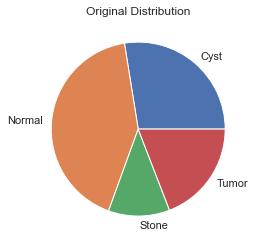

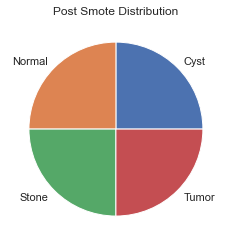

In [18]:
# SMOTE to balance classes

# Original class distribution
print('Training Set')
unique, counts = np.unique(y_train_new, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
XtrainsmoteNew, ytrainsmoteNew = oversample.fit_resample(X_train_new, y_train_new)


# Updated class distribution
uniquesmote, countssmote = np.unique(ytrainsmoteNew, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [19]:
np.random.seed(42)
indices = np.arange(XtrainsmoteNew.shape[0])
shuffled_indices = np.random.permutation(indices)
X_trainshuf_new = XtrainsmoteNew[shuffled_indices]
y_trainshuf_new = ytrainsmoteNew[shuffled_indices]
print(X_train_new.shape)
print(X_trainshuf_new.shape)
print(y_trainshuf_new.shape)

indices = np.arange(X_val_new.shape[0])
shuffled_indices = np.random.permutation(indices)
X_valshuf_new = X_val_new[shuffled_indices]
y_valshuf_new = y_val_new[shuffled_indices]
print(X_val_new.shape)
print(X_valshuf_new.shape)
print(y_valshuf_new.shape)


indices = np.arange(X_test_new.shape[0])
shuffled_indices = np.random.permutation(indices)
X_testshuf_new = X_test_new[shuffled_indices]
y_testshuf_new = y_test_new[shuffled_indices]
print(X_test_new.shape)
print(X_testshuf_new.shape)
print(y_testshuf_new.shape)

(7156, 65536)
(12004, 65536)
(12004,)
(2384, 65536)
(2384, 65536)
(2384, 1)
(2389, 65536)
(2389, 65536)
(2389, 1)


## OLD PREPROCESSING FLOW BELOW

In [ ]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [ ]:
imgs

In [ ]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [ ]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [ ]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [ ]:
if carrigan:
  X = np.load('/content/drive/MyDrive/Kidney Project Data/X.npy', allow_pickle=True)
  y = np.load('/content/drive/MyDrive/Kidney Project Data/y.npy', allow_pickle=True)

### Drop Duplicates

In [ ]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

In [ ]:
X_and_y = np.column_stack((X, y))
print(X_and_y.shape)

In [ ]:
X_and_y = pd.DataFrame(X_and_y)
X_and_y = X_and_y.drop_duplicates()
print(X_and_y.shape)

In [ ]:
X = X_and_y.iloc[:,:-1].to_numpy()
y = X_and_y.iloc[:,-1:].to_numpy()
print(X.shape)
print(y.shape)

### Perform SMOTE

In [ ]:
# Divide by 255, keep as float32 data
# print(np.max(X))
# X = (X.astype(np.float32) / 255.0).astype(np.float32)
# print(np.max(X))

In [ ]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [ ]:
del X
del y
del X_and_y

### Shuffle & reshape the data

In [ ]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]
print(Xshuffled.shape)

In [ ]:
del Xsmote
del ysmote

### Train and test split

In [ ]:
X_train_flat, X_test_flat, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [ ]:
# Create an intermediary validation set
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=1)

In [ ]:
# Reshape the data to 4 dimensional data
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))

In [ ]:
del Xshuffled
del yshuffled

## HERE UPDATES OLD NAMES TO NEW NAMES
#### Start back here if skipping old processing flow

In [20]:
print(np.max(X_trainshuf_new))
X_trainrescale_new = (X_trainshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_valrescale_new = (X_valshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_testrescale_new = (X_testshuf_new.astype(np.float32) / 255.0).astype(np.float32)
print(np.max(X_testrescale_new))

255
1.0


In [141]:
X_train_flat = X_trainrescale_new
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
y_train = y_trainshuf_new

X_val_flat = X_valrescale_new
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))
y_val = y_valshuf_new
y_val = y_val.reshape((len(y_val), ))

X_test_flat = X_testrescale_new
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
y_test = y_testshuf_new
y_test = y_test.reshape((len(y_test), ))

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(12004, 256, 256, 1) (2384, 256, 256, 1) (2389, 256, 256, 1)
(12004, 65536) (2384, 65536) (2389, 65536)
(12004,) (2384,) (2389,)


### Image Augmentation

In [22]:
# Create augmentation layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])


(256, 256, 1)


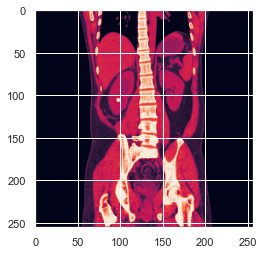

In [23]:
example_image = X_train[2]
print(example_image.shape)

plt.imshow(example_image)

In [25]:
plt.figure(figsize=(8, 7))
for i in range(6):
  aug_image = data_augmentation(example_image)
  ax = plt.subplot(2, 3, i + 1)
  plt.axis("off")

plt.show()

# Create Models

#### Create functions for class by class precision and recall

In [26]:
def recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())


def precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())


In [27]:
def recall_c1(y_true, y_pred):
    return recall(y_true, y_pred, 0)

def precision_c1(y_true, y_pred):
    return precision(y_true, y_pred, 0)

def recall_c2(y_true, y_pred):
    return recall(y_true, y_pred, 1)

def precision_c2(y_true, y_pred):
    return precision(y_true, y_pred, 1)

def recall_c3(y_true, y_pred):
    return recall(y_true, y_pred, 2)

def precision_c3(y_true, y_pred):
    return precision(y_true, y_pred, 2)

def recall_c4(y_true, y_pred):
    return recall(y_true, y_pred, 3)

def precision_c4(y_true, y_pred):
    return precision(y_true, y_pred, 3)

In [42]:
def allClassPrecisionsandRecalls(y_true, y_pred):
#     RECALL: true positives/ true positives + false negatives
#     PRECISION: true positives/true positives + false positives
    truePositives = {0:0, 1:0, 2:0, 3:0}
    falsePositives = {0:0, 1:0, 2:0, 3:0}
    falseNegatives = {0:0, 1:0, 2:0, 3:0}
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            truePositives[y_true[i]] += 1
        else:
            falseNegatives[y_true[i]] += 1
            falsePositives[y_pred[i]] += 1
    
    precisions = [truePositives[i]/(truePositives[i] + falsePositives[i]) for i in range(4)]
    recalls = [truePositives[i]/(truePositives[i] + falseNegatives[i]) for i in range(4)]
    
    accuracy = sum([truePositives[i] for i in range(4)])/len(y_true)
    
    return accuracy, precisions, recalls
        

## Classical Machine Learning Models

### Model 1 - Multiclass Classifier

In [28]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        data_augmentation,
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    return model

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = build_multiclass_model(4, 0.001)
numEpochs = 20

startTime = time.time()
history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=numEpochs,
  batch_size=64,
  validation_data = (X_val, y_val),
  verbose=1)
endTime = time.time()

Epoch 1/20
188/188 [==============================] - 8s 36ms/step - loss: 1.4220 - accuracy: 0.2517 - recall_c1: 0.2607 - precision_c1: 0.2480 - recall_c2: 0.2554 - precision_c2: 0.2352 - recall_c3: 0.2427 - precision_c3: 0.2312 - recall_c4: 0.2552 - precision_c4: 0.2484 - val_loss: 1.3949 - val_accuracy: 0.2995 - val_recall_c1: 0.4862 - val_precision_c1: 0.4704 - val_recall_c2: 0.0710 - val_precision_c2: 0.2567 - val_recall_c3: 0.2771 - val_precision_c3: 0.1435 - val_recall_c4: 0.5253 - val_precision_c4: 0.2694
Epoch 2/20
188/188 [==============================] - 5s 29ms/step - loss: 1.4039 - accuracy: 0.2687 - recall_c1: 0.2928 - precision_c1: 0.2714 - recall_c2: 0.2789 - precision_c2: 0.2753 - recall_c3: 0.2375 - precision_c3: 0.2320 - recall_c4: 0.2611 - precision_c4: 0.2378 - val_loss: 1.2704 - val_accuracy: 0.4237 - val_recall_c1: 0.5287 - val_precision_c1: 0.4442 - val_recall_c2: 0.6285 - val_precision_c2: 0.4468 - val_recall_c3: 0.0469 - val_precision_c3: 0.1779 - val_recall_

Epoch 17/20
188/188 [==============================] - 5s 28ms/step - loss: 1.3627 - accuracy: 0.3257 - recall_c1: 0.3896 - precision_c1: 0.3142 - recall_c2: 0.3553 - precision_c2: 0.3318 - recall_c3: 0.2499 - precision_c3: 0.3024 - recall_c4: 0.2843 - precision_c4: 0.3164 - val_loss: 1.4136 - val_accuracy: 0.3117 - val_recall_c1: 0.3193 - val_precision_c1: 0.6677 - val_recall_c2: 0.1783 - val_precision_c2: 0.4770 - val_recall_c3: 0.4016 - val_precision_c3: 0.1651 - val_recall_c4: 0.5293 - val_precision_c4: 0.2298
Epoch 18/20
188/188 [==============================] - 6s 30ms/step - loss: 1.3671 - accuracy: 0.3149 - recall_c1: 0.3760 - precision_c1: 0.3227 - recall_c2: 0.3275 - precision_c2: 0.3328 - recall_c3: 0.2671 - precision_c3: 0.2930 - recall_c4: 0.2679 - precision_c4: 0.2934 - val_loss: 1.3091 - val_accuracy: 0.3612 - val_recall_c1: 0.3014 - val_precision_c1: 0.6627 - val_recall_c2: 0.4327 - val_precision_c2: 0.4890 - val_recall_c3: 0.2988 - val_precision_c3: 0.1618 - val_recal

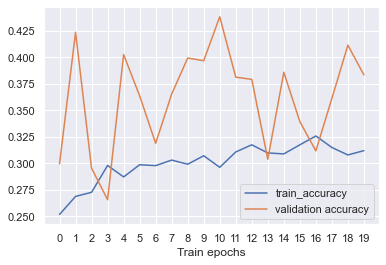

In [31]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [34]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.422027,0.251666,0.260736,0.247989,0.255383,0.235156,0.242671,0.231222,0.255230,0.248381,1.394883,0.299497,0.486210,0.470374,0.070989,0.256681,0.277136,0.143534,0.525322,0.269350
1,1.403898,0.268660,0.292769,0.271407,0.278860,0.275302,0.237473,0.232038,0.261066,0.237820,1.270436,0.423658,0.528741,0.444163,0.628521,0.446781,0.046880,0.177945,0.048522,0.183459
2,1.399959,0.272576,0.320491,0.291695,0.296719,0.249894,0.240147,0.232117,0.243444,0.239648,1.361158,0.295302,0.294495,0.712886,0.159768,0.394894,0.000000,0.000000,0.756013,0.205104
3,1.383234,0.297901,0.351190,0.310935,0.343626,0.279896,0.221332,0.270607,0.267696,0.271502,1.390249,0.265520,0.189983,0.766009,0.141296,0.420330,0.505642,0.157600,0.488762,0.221935
4,1.389140,0.287071,0.346850,0.297702,0.317916,0.290906,0.248467,0.257158,0.234242,0.242741,1.198749,0.402685,0.329224,0.546188,0.660949,0.442196,0.000000,0.000000,0.175598,0.165655
5,1.377270,0.298567,0.367044,0.342066,0.336505,0.305047,0.245497,0.272847,0.253917,0.259951,1.229830,0.363674,0.204971,0.733991,0.617755,0.420152,0.091053,0.163158,0.183839,0.146884
6,1.384929,0.297734,0.354625,0.303252,0.333537,0.293044,0.241864,0.256547,0.255167,0.269390,1.379096,0.318792,0.417917,0.563253,0.091144,0.533897,0.015227,0.070175,0.848956,0.239502
7,1.376868,0.302982,0.375754,0.320474,0.320029,0.280110,0.240998,0.258720,0.265918,0.270555,1.296337,0.365352,0.542358,0.461303,0.403400,0.458350,0.209856,0.130393,0.115750,0.177154
8,1.382351,0.299067,0.364474,0.309506,0.321611,0.296024,0.252483,0.260477,0.255986,0.239453,1.262579,0.399329,0.428094,0.467435,0.531250,0.463048,0.037147,0.149123,0.294274,0.239222
9,1.374202,0.307064,0.384017,0.322214,0.333470,0.300929,0.233446,0.280819,0.270695,0.268759,1.232272,0.396812,0.375932,0.462252,0.582196,0.452867,0.046107,0.118860,0.230735,0.225417


In [47]:
test_predictions = np.argmax(model1.predict(X_val), axis=-1)


75/75 [==============================] - 0s 2ms/step


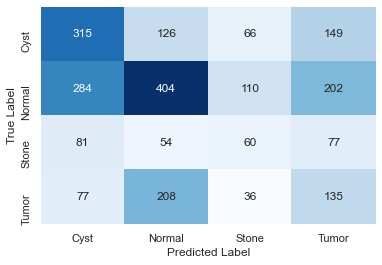

In [48]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [49]:
test_predictions = np.argmax(model1.predict(X_test), axis=-1)
print(test_predictions)

model1accuracy, model1precisions, model1recalls = allClassPrecisionsandRecalls(list(y_test), list(test_predictions))

model1accuracy, model1precisions, model1recalls

75/75 [==============================] - 0s 2ms/step
[1 3 3 ... 1 2 1]


(0.3457513604018418,
 [0.2980132450331126,
  0.43546441495778043,
  0.35359116022099446,
  0.2769556025369979],
 [0.41033434650455924,
  0.36063936063936064,
  0.23529411764705882,
  0.28602620087336245])

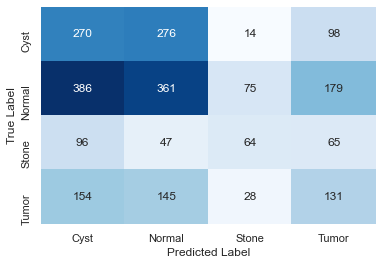

In [50]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [51]:
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 1.8907287160555521 minutes


### Model 2 - KNN

In [52]:
model2 = KNeighborsClassifier(n_neighbors=70, p=2, metric='minkowski')
startTime = time.time()
model2.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 0.10857545137405396 minutes


error: 0.6635906040268457
Val prediction accuracy: 0.336


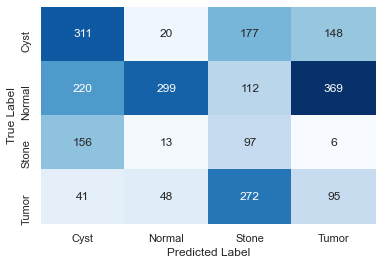

In [53]:
y_pred = model2.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

[3 3 2 ... 1 2 0]
error: 0.6107157806613646
Test prediction accuracy: 0.389


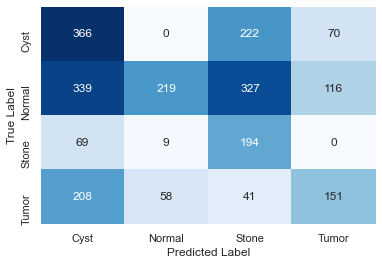

In [54]:
y_pred = model2.predict(X_test_flat)


error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [55]:
model2accuracy, model2precisions, model2recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

model2accuracy, model2precisions, model2recalls

(0.38928421933863544,
 [0.3727087576374745,
  0.7657342657342657,
  0.24744897959183673,
  0.44807121661721067],
 [0.5562310030395137,
  0.21878121878121878,
  0.7132352941176471,
  0.3296943231441048])

### Model 3: Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydot
from IPython.display import Image, display

In [57]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
startTime = time.time()
dt.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')
print('Val accuracy:', dt.score(X_val_flat, y_val))
print('Test accuracy:', dt.score(X_test_flat, y_test))


Training took 4.610515634218852 minutes
Val accuracy: 0.44043624161073824
Test accuracy: 0.42737547090832984


In [60]:
y_pred = dt.predict(X_test_flat)

model3accuracy, model3precisions, model3recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

model3accuracy, model3precisions, model3recalls

(0.42737547090832984,
 [0.4861111111111111,
  0.7687188019966722,
  0.10674157303370786,
  0.2532467532467532],
 [0.5851063829787234,
  0.46153846153846156,
  0.20955882352941177,
  0.2554585152838428])

Output: /Users/karachristensen/MidsWork/207/CarriganNeginKaraFinalProject/iris-decisiontree.jpg


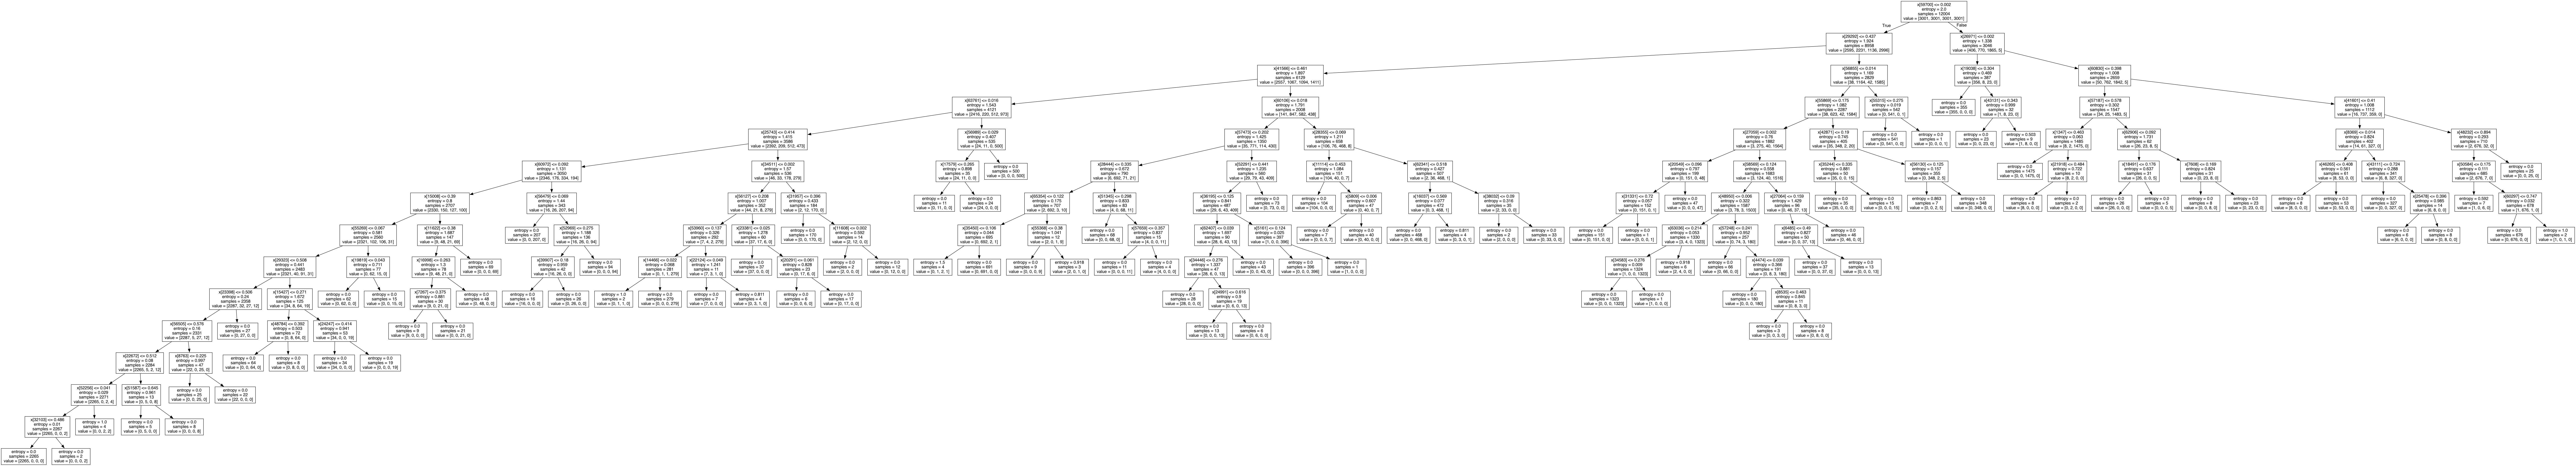

In [58]:
# Export and visualize the trained tree
import os

output_name = 'iris-decisiontree.jpg'
full_path = os.path.join(os.getcwd(), output_name)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]

graph.write_png(output_name)
print('Output:', full_path)
display(Image(filename=full_path))

## Neural Network Machine Learning Models

### Model 4 - Neural Network

##### For this model, we will look at 3 different parameter settings, and choose the one with the highest accuracy

In [89]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(data_augmentation)
    model.add(tf.keras.layers.Flatten())
    
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                       recall_c1,
                       precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


In [90]:
# Build and compile the model
model4_sgd = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                         optimizer='SGD', learning_rate=0.001)
numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_sgd.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()


model4_sgdTime = endTime - startTime

Epoch 1/15
188/188 [==============================] - 12s 60ms/step - loss: 1.3958 - accuracy: 0.2589 - recall_c1: 0.2196 - precision_c1: 0.2943 - recall_c2: 0.3000 - precision_c2: 0.2415 - recall_c3: 0.2821 - precision_c3: 0.2548 - recall_c4: 0.2317 - precision_c4: 0.2286 - val_loss: 1.3610 - val_accuracy: 0.3247 - val_recall_c1: 0.3833 - val_precision_c1: 0.3664 - val_recall_c2: 0.4644 - val_precision_c2: 0.4280 - val_recall_c3: 0.1392 - val_precision_c3: 0.1992 - val_recall_c4: 0.0334 - val_precision_c4: 0.0401
Epoch 2/15
188/188 [==============================] - 10s 54ms/step - loss: 1.3888 - accuracy: 0.2621 - recall_c1: 0.2597 - precision_c1: 0.2877 - recall_c2: 0.3149 - precision_c2: 0.2553 - recall_c3: 0.2490 - precision_c3: 0.2410 - recall_c4: 0.2262 - precision_c4: 0.2324 - val_loss: 1.3467 - val_accuracy: 0.3712 - val_recall_c1: 0.5152 - val_precision_c1: 0.4227 - val_recall_c2: 0.5020 - val_precision_c2: 0.4661 - val_recall_c3: 0.1473 - val_precision_c3: 0.2689 - val_recal

Epoch 14/15
188/188 [==============================] - 10s 52ms/step - loss: 1.3658 - accuracy: 0.2966 - recall_c1: 0.4104 - precision_c1: 0.2969 - recall_c2: 0.3812 - precision_c2: 0.2944 - recall_c3: 0.1870 - precision_c3: 0.2611 - recall_c4: 0.1891 - precision_c4: 0.2675 - val_loss: 1.2840 - val_accuracy: 0.3674 - val_recall_c1: 0.5744 - val_precision_c1: 0.4244 - val_recall_c2: 0.4212 - val_precision_c2: 0.4777 - val_recall_c3: 0.1163 - val_precision_c3: 0.3110 - val_recall_c4: 0.1057 - val_precision_c4: 0.1040
Epoch 15/15
188/188 [==============================] - 10s 53ms/step - loss: 1.3571 - accuracy: 0.3182 - recall_c1: 0.4373 - precision_c1: 0.3351 - recall_c2: 0.3985 - precision_c2: 0.3262 - recall_c3: 0.2037 - precision_c3: 0.2800 - recall_c4: 0.2181 - precision_c4: 0.2638 - val_loss: 1.2491 - val_accuracy: 0.4291 - val_recall_c1: 0.5338 - val_precision_c1: 0.4237 - val_recall_c2: 0.6286 - val_precision_c2: 0.5055 - val_recall_c3: 0.1150 - val_precision_c3: 0.2075 - val_rec

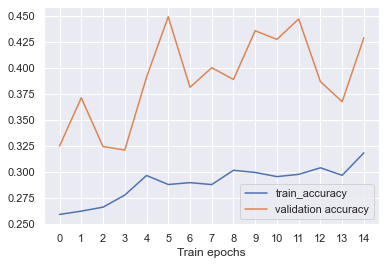

In [92]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [93]:
model4_sgdFinalValAcc = val_accuracy[numEpochs - 1]

In [94]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.395753,0.258914,0.219564,0.294350,0.299979,0.241497,0.282139,0.254828,0.231680,0.228576,1.361014,0.324664,0.383264,0.366360,0.464434,0.427986,0.139184,0.199218,0.033360,0.040074
1,1.388814,0.262079,0.259720,0.287738,0.314890,0.255287,0.249012,0.241030,0.226200,0.232447,1.346722,0.371225,0.515219,0.422722,0.501977,0.466077,0.147288,0.268860,0.002392,0.002392
2,1.385091,0.265911,0.279173,0.287173,0.346122,0.273568,0.227415,0.243812,0.214207,0.257745,1.352980,0.324245,0.369446,0.463626,0.386507,0.434449,0.411987,0.411613,0.073006,0.056992
3,1.381502,0.277491,0.300057,0.284797,0.364738,0.292122,0.228511,0.252455,0.217624,0.248613,1.361369,0.320889,0.441374,0.474166,0.276051,0.529553,0.604505,0.246401,0.076671,0.078806
4,1.373955,0.296401,0.342444,0.310865,0.363836,0.313949,0.254643,0.277162,0.224352,0.284907,1.296720,0.390940,0.613352,0.419175,0.491759,0.489432,0.053740,0.342105,0.048581,0.053610
5,1.376791,0.287737,0.356673,0.307508,0.377625,0.307041,0.199610,0.273642,0.220999,0.257584,1.265527,0.449245,0.438845,0.503207,0.678103,0.501683,0.287967,0.295850,0.053658,0.108584
6,1.374731,0.289487,0.364373,0.319500,0.385173,0.297464,0.231505,0.272006,0.174230,0.249844,1.323744,0.381292,0.576079,0.456185,0.400534,0.533496,0.315651,0.273415,0.115609,0.110726
7,1.374312,0.287654,0.362471,0.308913,0.358879,0.289386,0.216884,0.250948,0.208727,0.266963,1.340833,0.400168,0.810431,0.401001,0.369650,0.511784,0.113107,0.294361,0.057836,0.100909
8,1.366133,0.301400,0.398066,0.320837,0.377661,0.304485,0.208390,0.273844,0.217917,0.263953,1.283737,0.388842,0.553622,0.418104,0.494878,0.491710,0.078343,0.407895,0.102174,0.099103
9,1.367421,0.299317,0.403925,0.321940,0.375673,0.309561,0.182576,0.261929,0.226894,0.282224,1.244223,0.435822,0.536191,0.412726,0.647629,0.485053,0.067243,0.264912,0.054863,0.159806


In [83]:
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')

75/75 [==============================] - 1s 7ms/step


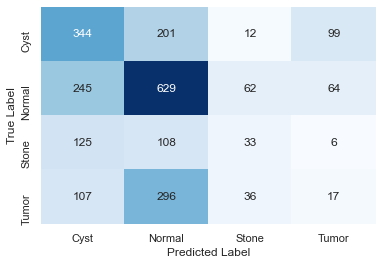

In [98]:
test_predictions = model4_sgd.predict(X_val)
y_pred = np.argmax(test_predictions, axis=-1)



# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [99]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [100]:
model4_rms = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                         optimizer='RMSprop', learning_rate=0.001)

numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_rms.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()
model4_rmsTime = endTime - startTime

Epoch 1/15
188/188 [==============================] - 39s 196ms/step - loss: 8.4969 - accuracy: 0.2540 - recall_c1: 0.2695 - precision_c1: 0.0891 - recall_c2: 0.2490 - precision_c2: 0.0961 - recall_c3: 0.2412 - precision_c3: 0.0798 - recall_c4: 0.2574 - precision_c4: 0.0873 - val_loss: 7.8750 - val_accuracy: 0.1913 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 1.0000 - val_precision_c4: 0.1937
Epoch 2/15
188/188 [==============================] - 36s 189ms/step - loss: 3.6170 - accuracy: 0.2557 - recall_c1: 0.2692 - precision_c1: 0.1152 - recall_c2: 0.2460 - precision_c2: 0.0971 - recall_c3: 0.2436 - precision_c3: 0.0846 - recall_c4: 0.2703 - precision_c4: 0.0908 - val_loss: 2.2608 - val_accuracy: 0.3821 - val_recall_c1: 0.4651 - val_precision_c1: 0.2861 - val_recall_c2: 0.5960 - val_precision_c2: 0.5232 - val_recall_c3: 0.0570 - val_precis

188/188 [==============================] - 35s 187ms/step - loss: 1.3796 - accuracy: 0.2822 - recall_c1: 0.2748 - precision_c1: 0.2245 - recall_c2: 0.8230 - precision_c2: 0.2784 - recall_c3: 0.0169 - precision_c3: 0.0678 - recall_c4: 0.0133 - precision_c4: 0.0658 - val_loss: 1.4707 - val_accuracy: 0.3876 - val_recall_c1: 0.8322 - val_precision_c1: 0.3486 - val_recall_c2: 0.3772 - val_precision_c2: 0.4956 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.0022 - val_precision_c4: 0.0066
Epoch 14/15
188/188 [==============================] - 35s 186ms/step - loss: 1.3770 - accuracy: 0.2900 - recall_c1: 0.3360 - precision_c1: 0.2472 - recall_c2: 0.7820 - precision_c2: 0.2805 - recall_c3: 0.0183 - precision_c3: 0.0641 - recall_c4: 0.0166 - precision_c4: 0.0861 - val_loss: 1.5227 - val_accuracy: 0.2324 - val_recall_c1: 0.5498 - val_precision_c1: 0.4446 - val_recall_c2: 0.0535 - val_precision_c2: 0.3771 - val_recall_c3: 0.5083 - val_precision_c3: 0.0926 - val_recal

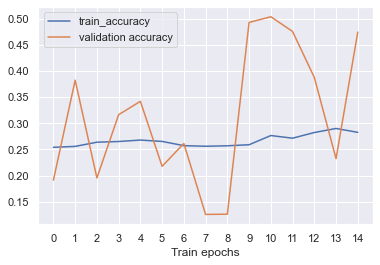

In [101]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [102]:
model4_rmsFinalValAcc = val_accuracy[numEpochs - 1]

In [103]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,8.496861,0.253999,0.269546,0.089094,0.248972,0.096133,0.241151,0.079798,0.257417,0.087271,7.874979,0.191275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.193668
1,3.617026,0.255748,0.269187,0.115158,0.246018,0.097062,0.243571,0.084554,0.270308,0.090803,2.260758,0.382131,0.465051,0.286131,0.596038,0.523235,0.057007,0.091479,0.000000,0.000000
2,2.449773,0.263745,0.309768,0.132793,0.250911,0.136715,0.210359,0.114737,0.281233,0.114820,1.977783,0.195470,0.000000,0.000000,0.206894,0.416591,0.842500,0.128410,0.034615,0.197807
3,2.123910,0.265078,0.299365,0.150768,0.229557,0.118667,0.232668,0.118812,0.296040,0.141019,2.002603,0.316275,0.914427,0.282911,0.149754,0.598192,0.000000,0.000000,0.000000,0.000000
4,1.782927,0.267827,0.301182,0.165924,0.257252,0.163258,0.221143,0.104117,0.282220,0.143486,1.671902,0.341862,0.900509,0.332422,0.000000,0.000000,0.000000,0.000000,0.497610,0.379592
5,1.607318,0.265245,0.372980,0.203617,0.271560,0.141019,0.159113,0.099041,0.285763,0.150971,1.443837,0.217701,0.164616,0.660401,0.000000,0.000000,0.135155,0.116495,0.829091,0.199184
6,1.446869,0.257164,0.226153,0.149718,0.193995,0.110985,0.465995,0.160570,0.164130,0.083795,1.376758,0.261326,0.887254,0.344083,0.000000,0.000000,0.158837,0.062174,0.000000,0.000000
7,1.388958,0.255998,0.134898,0.132385,0.132681,0.041071,0.701774,0.190410,0.062046,0.044621,1.387691,0.125839,0.132868,0.361894,0.000000,0.000000,0.771018,0.098852,0.000000,0.000000
8,1.399909,0.256914,0.126545,0.137836,0.000000,0.000000,0.448407,0.158855,0.453340,0.130954,1.383675,0.126258,0.152151,0.416108,0.000000,0.000000,0.725653,0.093091,0.000000,0.000000
9,1.385473,0.258914,0.168251,0.163472,0.718218,0.208152,0.156579,0.109253,0.007079,0.013409,1.372973,0.492450,0.266997,0.706683,0.999203,0.467180,0.000000,0.000000,0.000000,0.000000


In [86]:
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [87]:
test_predictions = model4_rms.predict(X_val)
y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [104]:
model4_adam = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                          optimizer='Adam', learning_rate=0.0001)

numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_adam.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()

model4_adamTime = endTime - startTime


Epoch 1/15
188/188 [==============================] - 21s 106ms/step - loss: 1.4289 - accuracy: 0.2504 - recall_c1: 0.2695 - precision_c1: 0.1852 - recall_c2: 0.3246 - precision_c2: 0.1679 - recall_c3: 0.1962 - precision_c3: 0.1114 - recall_c4: 0.2348 - precision_c4: 0.1717 - val_loss: 1.2738 - val_accuracy: 0.4153 - val_recall_c1: 0.4050 - val_precision_c1: 0.3069 - val_recall_c2: 0.7182 - val_precision_c2: 0.4858 - val_recall_c3: 0.0248 - val_precision_c3: 0.0855 - val_recall_c4: 0.0000e+00 - val_precision_c4: 0.0000e+00
Epoch 2/15
188/188 [==============================] - 19s 103ms/step - loss: 1.3870 - accuracy: 0.2685 - recall_c1: 0.2335 - precision_c1: 0.1924 - recall_c2: 0.4038 - precision_c2: 0.2331 - recall_c3: 0.2710 - precision_c3: 0.1573 - recall_c4: 0.1654 - precision_c4: 0.1496 - val_loss: 1.3985 - val_accuracy: 0.2664 - val_recall_c1: 0.1456 - val_precision_c1: 0.8544 - val_recall_c2: 0.3087 - val_precision_c2: 0.4832 - val_recall_c3: 0.6512 - val_precision_c3: 0.1587 -

Epoch 14/15
188/188 [==============================] - 20s 105ms/step - loss: 1.3524 - accuracy: 0.3293 - recall_c1: 0.4260 - precision_c1: 0.3106 - recall_c2: 0.4405 - precision_c2: 0.3238 - recall_c3: 0.2413 - precision_c3: 0.2966 - recall_c4: 0.2011 - precision_c4: 0.2873 - val_loss: 1.3534 - val_accuracy: 0.3180 - val_recall_c1: 0.5659 - val_precision_c1: 0.3813 - val_recall_c2: 0.2274 - val_precision_c2: 0.4080 - val_recall_c3: 0.3101 - val_precision_c3: 0.1814 - val_recall_c4: 0.1798 - val_precision_c4: 0.1917
Epoch 15/15
188/188 [==============================] - 19s 102ms/step - loss: 1.3355 - accuracy: 0.3441 - recall_c1: 0.4655 - precision_c1: 0.3387 - recall_c2: 0.4422 - precision_c2: 0.3598 - recall_c3: 0.2356 - precision_c3: 0.3059 - recall_c4: 0.2187 - precision_c4: 0.3146 - val_loss: 1.2855 - val_accuracy: 0.4165 - val_recall_c1: 0.4976 - val_precision_c1: 0.3714 - val_recall_c2: 0.6035 - val_precision_c2: 0.5068 - val_recall_c3: 0.2351 - val_precision_c3: 0.2040 - val_r

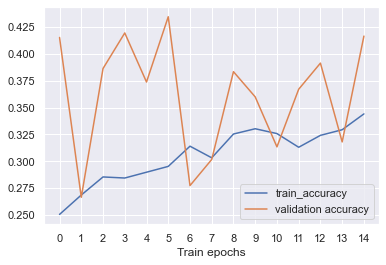

In [105]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [106]:
model4_adamFinalValAcc = val_accuracy[numEpochs - 1]

In [107]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.428860,0.250417,0.269541,0.185240,0.324641,0.167893,0.196181,0.111358,0.234776,0.171714,1.273831,0.415268,0.405009,0.306923,0.718227,0.485792,0.024812,0.085526,0.000000,0.000000
1,1.386977,0.268494,0.233463,0.192416,0.403754,0.233071,0.271044,0.157324,0.165399,0.149578,1.398458,0.266359,0.145613,0.854386,0.308706,0.483250,0.651196,0.158726,0.107067,0.088440
2,1.377642,0.285322,0.287980,0.263204,0.434627,0.274044,0.294125,0.251636,0.130865,0.152563,1.304674,0.386326,0.399120,0.345913,0.563721,0.518429,0.360722,0.184640,0.000000,0.000000
3,1.375126,0.284322,0.263369,0.243443,0.440506,0.258953,0.280517,0.204223,0.140521,0.170696,1.290205,0.419463,0.419206,0.351106,0.636546,0.506289,0.319462,0.263142,0.007778,0.061404
4,1.374048,0.289737,0.299070,0.254245,0.416590,0.289370,0.263047,0.218162,0.188455,0.211270,1.294704,0.373742,0.280475,0.411393,0.573300,0.532780,0.468079,0.161320,0.011302,0.078321
5,1.369825,0.295152,0.394738,0.291181,0.400230,0.277082,0.209557,0.231906,0.180772,0.218632,1.242018,0.434564,0.448557,0.374235,0.670569,0.506674,0.258913,0.286792,0.011302,0.072368
6,1.359724,0.313979,0.340922,0.294027,0.493900,0.327155,0.287485,0.246681,0.116935,0.238400,1.363180,0.277265,0.457728,0.358905,0.065249,0.346554,0.261984,0.172934,0.497375,0.225768
7,1.364834,0.303149,0.384471,0.317723,0.417504,0.281477,0.257588,0.272378,0.159102,0.257494,1.356939,0.301594,0.496169,0.429978,0.106183,0.258122,0.325375,0.239040,0.446996,0.231432
8,1.351330,0.325308,0.397274,0.308317,0.424547,0.334642,0.247953,0.289700,0.199215,0.267025,1.264298,0.383389,0.483817,0.376689,0.482922,0.467653,0.237934,0.266531,0.137780,0.190563
9,1.345153,0.330223,0.438093,0.324120,0.450813,0.343735,0.207191,0.285089,0.208676,0.292601,1.259216,0.359899,0.433499,0.356741,0.432200,0.424831,0.161804,0.186104,0.206414,0.253739


In [81]:
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 4.9663851141929625 minutes


In [ ]:

test_predictions = model4_adam.predict(X_val)
y_pred = np.argmax(test_predictions, axis=-1)

# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

The best optimizer was RMS
Training took 8.911616667111714 minutes
75/75 [==============================] - 1s 16ms/step


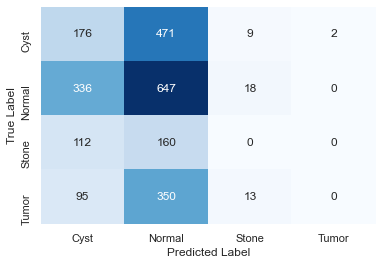

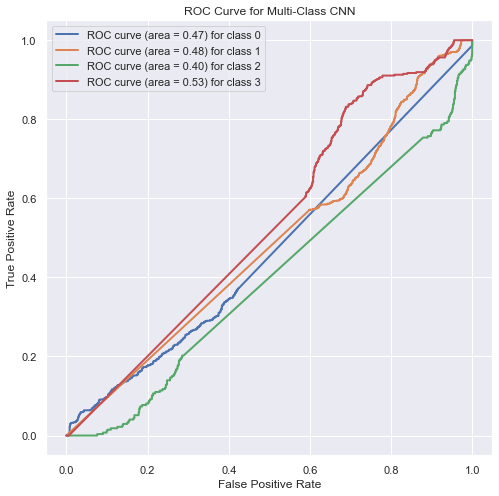

(0.3444956048555881,
 [0.24478442280945759, 0.3974201474201474, 0.0, 0.0],
 [0.2674772036474164, 0.6463536463536463, 0.0, 0.0])

In [138]:
# Find which model is best, and run relevant methods

model4_sgdTime, model4_rmsTime, model4_adamTime
model4_sgdFinalValAcc, model4_rmsFinalValAcc, model4_adamFinalValAcc

if model4_sgdFinalValAcc >= model4_rmsFinalValAcc and model4_sgdFinalValAcc >= model4_adamFinalValAcc:
    print('The best optimizer was SGD')
    print('Training took ' + str(model4_sgdTime/60) + ' minutes')
    test_predictions = model4_sgd.predict(X_test)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model4accuracy, model4precisions, model4recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()


elif model4_rmsFinalValAcc >= model4_sgdFinalValAcc and model4_rmsFinalValAcc >= model4_adamFinalValAcc:
    print('The best optimizer was RMS')
    print('Training took ' + str(model4_rmsTime/60) + ' minutes')
    test_predictions = model4_rms.predict(X_test)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model4accuracy, model4precisions, model4recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))


    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

   # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
else:
    print('The best optimizer was Adam')
    print('Training took ' + str(model4_adamTime/60) + ' minutes')

    test_predictions = model4adam.predict(X_test)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model4accuracy, model4precisions, model4recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

   # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()

model4accuracy, model4precisions, model4recalls

### Models 5-6 - CNN

In [110]:
def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):

    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [111]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [112]:
#new_shape = (32, 32, 3)
X_train_reshaped = np.reshape(X_train_flat, (-1, 256, 256, 1))
X_val_reshaped = np.reshape(X_val_flat, (-1, 256, 256, 1))
X_test_reshaped = np.reshape(X_test_flat, (-1, 256, 256, 1))
# Normalize pixel values to range [0, 1]
# X_train_reshaped = X_train_reshaped / 255.0
# X_val_reshaped = X_val_reshaped / 255.0
# X_test_reshaped = X_test_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])
X_test_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_test_reshaped])


In [113]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)


In [114]:
# Train the CNN model for 5 epochs
cnn_model_sgd = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.001)
numEpochs = 25
startTime = time.time()
history_cnn = cnn_model_sgd.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
model5_sgdTime = (endTime - startTime)

Epoch 1/25
188/188 [==============================] - 12s 46ms/step - loss: 1.3829 - accuracy: 0.2488 - recall_c1: 0.0000e+00 - precision_c1: 0.0000e+00 - recall_c2: 0.0074 - precision_c2: 0.0553 - recall_c3: 0.0000e+00 - precision_c3: 0.0000e+00 - recall_c4: 0.9892 - precision_c4: 0.2533 - val_loss: 1.3811 - val_accuracy: 0.1913 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 1.0000 - val_precision_c4: 0.1950
Epoch 2/25
188/188 [==============================] - 8s 42ms/step - loss: 1.3776 - accuracy: 0.2528 - recall_c1: 0.0000e+00 - precision_c1: 0.0000e+00 - recall_c2: 0.1657 - precision_c2: 0.1952 - recall_c3: 0.0000e+00 - precision_c3: 0.0000e+00 - recall_c4: 0.8458 - precision_c4: 0.2577 - val_loss: 1.3712 - val_accuracy: 0.2349 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.1386 - val_precision_c2: 0.4648

188/188 [==============================] - 8s 41ms/step - loss: 1.3322 - accuracy: 0.3740 - recall_c1: 0.3586 - precision_c1: 0.6833 - recall_c2: 0.9418 - precision_c2: 0.3306 - recall_c3: 0.0810 - precision_c3: 0.2974 - recall_c4: 0.1204 - precision_c4: 0.3371 - val_loss: 1.3035 - val_accuracy: 0.5382 - val_recall_c1: 0.3766 - val_precision_c1: 0.8363 - val_recall_c2: 0.9475 - val_precision_c2: 0.5902 - val_recall_c3: 0.0248 - val_precision_c3: 0.0445 - val_recall_c4: 0.1770 - val_precision_c4: 0.2649
Epoch 11/25
188/188 [==============================] - 8s 41ms/step - loss: 1.3241 - accuracy: 0.3960 - recall_c1: 0.4325 - precision_c1: 0.6612 - recall_c2: 0.9267 - precision_c2: 0.3450 - recall_c3: 0.0873 - precision_c3: 0.3126 - recall_c4: 0.1461 - precision_c4: 0.3791 - val_loss: 1.2906 - val_accuracy: 0.5415 - val_recall_c1: 0.4263 - val_precision_c1: 0.8279 - val_recall_c2: 0.9332 - val_precision_c2: 0.5927 - val_recall_c3: 0.0568 - val_precision_c3: 0.0789 - val_recall_c4: 0.1421

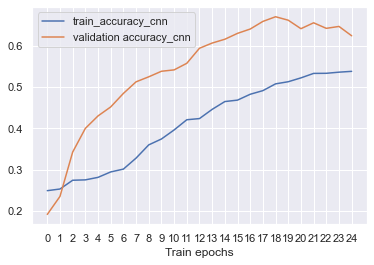

In [115]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [116]:
model5_sgdFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [117]:
history = pd.DataFrame(history_cnn.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.382925,0.248834,0.000000,0.000000,0.007405,0.055290,0.000000,0.000000,0.989182,0.253272,1.381103,0.191275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.195026
1,1.377624,0.252832,0.000000,0.000000,0.165692,0.195163,0.000000,0.000000,0.845845,0.257739,1.371215,0.234899,0.000000,0.000000,0.138637,0.464786,0.000000,0.000000,0.926521,0.206010
2,1.373144,0.274075,0.000000,0.000000,0.675694,0.279722,0.003286,0.045213,0.417803,0.267544,1.363094,0.342282,0.000000,0.000000,0.524115,0.545382,0.000000,0.000000,0.649154,0.212090
3,1.368645,0.274992,0.001804,0.021277,0.833083,0.280929,0.013625,0.101254,0.249210,0.259761,1.356595,0.399748,0.000000,0.000000,0.740696,0.557254,0.019330,0.105263,0.460349,0.210728
4,1.363567,0.281073,0.007447,0.100177,0.886225,0.287839,0.033621,0.176748,0.194668,0.270345,1.348806,0.429950,0.000000,0.000000,0.846193,0.544279,0.072296,0.220614,0.349818,0.212159
5,1.358477,0.294235,0.048195,0.435638,0.912171,0.294727,0.053180,0.211379,0.164208,0.270195,1.340504,0.451762,0.006552,0.105263,0.931821,0.545331,0.072193,0.151190,0.257936,0.230444
6,1.352661,0.301066,0.087196,0.533491,0.952771,0.293150,0.061596,0.232426,0.101765,0.280390,1.333230,0.484480,0.118870,0.670865,0.956292,0.571320,0.042587,0.071742,0.234230,0.244228
7,1.346386,0.327724,0.185660,0.695962,0.946900,0.304005,0.080293,0.284993,0.098546,0.310861,1.324796,0.512584,0.229394,0.815784,0.956582,0.580242,0.029429,0.052339,0.232669,0.268776
8,1.339539,0.359797,0.278543,0.674985,0.932835,0.322977,0.085409,0.309764,0.141704,0.329148,1.314204,0.524748,0.288400,0.835634,0.970421,0.581598,0.015362,0.027924,0.199230,0.266013
9,1.332199,0.374042,0.358611,0.683325,0.941815,0.330564,0.080966,0.297408,0.120365,0.337104,1.303521,0.538171,0.376647,0.836305,0.947548,0.590195,0.024803,0.044549,0.177035,0.264920


In [ ]:
# test_predictions = cnn_model_sgd.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [118]:
cnn_model_adam = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.0001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model_adam.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model5_adamTime = (endTime - startTime)

Epoch 1/15
188/188 [==============================] - 11s 47ms/step - loss: 1.2513 - accuracy: 0.4452 - recall_c1: 0.6504 - precision_c1: 0.4729 - recall_c2: 0.7992 - precision_c2: 0.4424 - recall_c3: 0.1124 - precision_c3: 0.2478 - recall_c4: 0.2233 - precision_c4: 0.3859 - val_loss: 1.2405 - val_accuracy: 0.3809 - val_recall_c1: 1.0000 - val_precision_c1: 0.4611 - val_recall_c2: 0.2112 - val_precision_c2: 1.0000 - val_recall_c3: 0.1006 - val_precision_c3: 0.0657 - val_recall_c4: 0.0509 - val_precision_c4: 0.0537
Epoch 2/15
188/188 [==============================] - 10s 56ms/step - loss: 1.0477 - accuracy: 0.5430 - recall_c1: 0.7471 - precision_c1: 0.5863 - recall_c2: 0.7282 - precision_c2: 0.5441 - recall_c3: 0.2809 - precision_c3: 0.4326 - recall_c4: 0.4207 - precision_c4: 0.6234 - val_loss: 1.2743 - val_accuracy: 0.4249 - val_recall_c1: 0.9920 - val_precision_c1: 0.4729 - val_recall_c2: 0.2683 - val_precision_c2: 1.0000 - val_recall_c3: 0.0516 - val_precision_c3: 0.0596 - val_recal

188/188 [==============================] - 8s 41ms/step - loss: 0.4111 - accuracy: 0.8560 - recall_c1: 0.8924 - precision_c1: 0.8685 - recall_c2: 0.8403 - precision_c2: 0.8544 - recall_c3: 0.8029 - precision_c3: 0.8075 - recall_c4: 0.8851 - precision_c4: 0.9095 - val_loss: 1.1484 - val_accuracy: 0.6082 - val_recall_c1: 0.7297 - val_precision_c1: 0.6624 - val_recall_c2: 0.6890 - val_precision_c2: 0.8166 - val_recall_c3: 0.2867 - val_precision_c3: 0.3592 - val_recall_c4: 0.4386 - val_precision_c4: 0.3438
Epoch 11/15
188/188 [==============================] - 8s 41ms/step - loss: 0.3854 - accuracy: 0.8675 - recall_c1: 0.9011 - precision_c1: 0.8613 - recall_c2: 0.8628 - precision_c2: 0.8728 - recall_c3: 0.8103 - precision_c3: 0.8315 - recall_c4: 0.8975 - precision_c4: 0.9216 - val_loss: 1.2978 - val_accuracy: 0.5877 - val_recall_c1: 0.8404 - val_precision_c1: 0.5712 - val_recall_c2: 0.6887 - val_precision_c2: 0.8648 - val_recall_c3: 0.1256 - val_precision_c3: 0.2290 - val_recall_c4: 0.2816

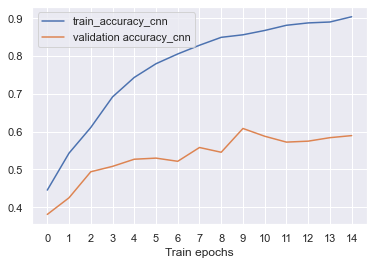

In [119]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [120]:
model5_adamFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [121]:
history = pd.DataFrame(history_cnn.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.251298,0.445185,0.650397,0.472864,0.799230,0.442408,0.112448,0.247767,0.223256,0.385885,1.240530,0.380872,1.000000,0.461108,0.211189,1.000000,0.100598,0.065716,0.050914,0.053678
1,1.047725,0.542986,0.747143,0.586284,0.728163,0.544134,0.280874,0.432640,0.420731,0.623445,1.274258,0.424916,0.991954,0.472945,0.268261,1.000000,0.051641,0.059564,0.187921,0.160034
2,0.901868,0.610796,0.768372,0.645756,0.720334,0.618694,0.406170,0.495640,0.546491,0.720972,1.202953,0.493708,0.856807,0.519636,0.414916,1.000000,0.217926,0.240894,0.311292,0.205809
3,0.764222,0.691603,0.793651,0.721828,0.731366,0.694531,0.549898,0.610282,0.687568,0.779643,1.199125,0.507970,0.834573,0.662303,0.454798,1.000000,0.525235,0.220943,0.122781,0.121931
4,0.671047,0.743252,0.829527,0.773014,0.743145,0.741153,0.651362,0.684530,0.747413,0.825862,1.197686,0.526846,0.829913,0.556736,0.538357,0.976619,0.223545,0.189012,0.241835,0.198318
5,0.596069,0.779490,0.866270,0.807538,0.759962,0.778209,0.694000,0.721930,0.794096,0.854148,1.278864,0.529782,0.880137,0.532984,0.589121,0.974403,0.187516,0.134393,0.098865,0.136506
6,0.537899,0.805315,0.867178,0.820672,0.802601,0.798831,0.728188,0.752437,0.822924,0.881347,1.388876,0.521393,0.798608,0.587703,0.466839,0.972485,0.098679,0.120333,0.476892,0.291624
7,0.484486,0.828391,0.879840,0.839604,0.813586,0.826383,0.766494,0.775086,0.853904,0.889801,1.296700,0.557886,0.857566,0.545352,0.622780,0.928092,0.061123,0.093045,0.277668,0.245607
8,0.440431,0.849300,0.894618,0.851822,0.844184,0.848242,0.791197,0.809173,0.867550,0.910488,1.389717,0.545302,0.843729,0.570593,0.550528,0.952259,0.102467,0.136418,0.359293,0.267630
9,0.411129,0.856048,0.892399,0.868538,0.840256,0.854429,0.802922,0.807489,0.885122,0.909478,1.148374,0.608221,0.729728,0.662406,0.689038,0.816597,0.286736,0.359169,0.438621,0.343756


In [ ]:
# test_predictions = cnn_model_adam.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [122]:
cnn_model_rms = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model_rms.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model5_rmsTime = (endTime - startTime)

Epoch 1/10
188/188 [==============================] - 11s 44ms/step - loss: 1.0851 - accuracy: 0.5090 - recall_c1: 0.6926 - precision_c1: 0.5730 - recall_c2: 0.6756 - precision_c2: 0.5080 - recall_c3: 0.2429 - precision_c3: 0.3685 - recall_c4: 0.4249 - precision_c4: 0.6056 - val_loss: 1.3214 - val_accuracy: 0.5415 - val_recall_c1: 0.6312 - val_precision_c1: 0.6021 - val_recall_c2: 0.6846 - val_precision_c2: 0.8904 - val_recall_c3: 0.5893 - val_precision_c3: 0.3035 - val_recall_c4: 0.0872 - val_precision_c4: 0.0883
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.6998 - accuracy: 0.7068 - recall_c1: 0.7868 - precision_c1: 0.7654 - recall_c2: 0.7025 - precision_c2: 0.7296 - recall_c3: 0.6024 - precision_c3: 0.6802 - recall_c4: 0.7421 - precision_c4: 0.8123 - val_loss: 1.4827 - val_accuracy: 0.6049 - val_recall_c1: 0.6381 - val_precision_c1: 0.6779 - val_recall_c2: 0.7808 - val_precision_c2: 0.8112 - val_recall_c3: 0.3894 - val_precision_c3: 0.3954 - val_recall

188/188 [==============================] - 8s 41ms/step - loss: 0.0475 - accuracy: 0.9834 - recall_c1: 0.9837 - precision_c1: 0.9840 - recall_c2: 0.9784 - precision_c2: 0.9841 - recall_c3: 0.9821 - precision_c3: 0.9827 - recall_c4: 0.9885 - precision_c4: 0.9864 - val_loss: 3.1051 - val_accuracy: 0.6447 - val_recall_c1: 0.6931 - val_precision_c1: 0.6988 - val_recall_c2: 0.7216 - val_precision_c2: 0.9041 - val_recall_c3: 0.2131 - val_precision_c3: 0.2991 - val_recall_c4: 0.6898 - val_precision_c4: 0.4341


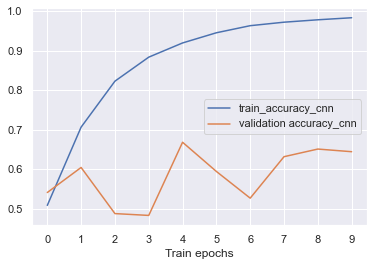

In [123]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [124]:
model5_rmsFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_rms.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)



# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

The best optimizer was RMS
Training took 1.3660415649414062 minutes
75/75 [==============================] - 0s 3ms/step


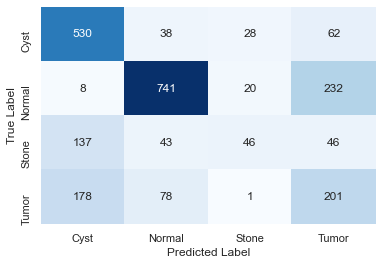

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [125]:
if model5_sgdFinalValAcc >= model5_rmsFinalValAcc and model5_sgdFinalValAcc >= model5_adamFinalValAcc:
    print('The best optimizer was SGD')
    print('Training took ' + str(model5_sgdTime/60) + ' minutes')
    test_predictions = cnn_model_sgd.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model5accuracy, model5precisions, model5recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
    
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()


elif model5_rmsFinalValAcc >= model5_sgdFinalValAcc and model5_rmsFinalValAcc >= model5_adamFinalValAcc:
    print('The best optimizer was RMS')
    print('Training took ' + str(model5_rmsTime/60) + ' minutes')
    test_predictions = cnn_model_rms.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model5accuracy, model5precisions, model5recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
else:
    print('The best optimizer was Adam')
    print('Training took ' + str(model5_adamTime/60) + ' minutes')
    test_predictions = cnn_model_adam.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model5accuracy, model5precisions, model5recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
    
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()

model5accuracy, model5precisions, model5recalls

In [126]:
#building a new CNN model increasing the number of filters

def build_new_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Adding drop out layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [127]:
cnn_model_rms = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model_rms.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
model6_rmsTime = (endTime - startTime)

Epoch 1/10
188/188 [==============================] - 12s 46ms/step - loss: 1.0879 - accuracy: 0.5088 - recall_c1: 0.6998 - precision_c1: 0.5735 - recall_c2: 0.6627 - precision_c2: 0.4971 - recall_c3: 0.2523 - precision_c3: 0.3963 - recall_c4: 0.4297 - precision_c4: 0.5953 - val_loss: 1.9906 - val_accuracy: 0.3599 - val_recall_c1: 0.8598 - val_precision_c1: 0.3375 - val_recall_c2: 0.3012 - val_precision_c2: 1.0000 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.0087 - val_precision_c4: 0.0100
Epoch 2/10
188/188 [==============================] - 7s 39ms/step - loss: 0.6711 - accuracy: 0.7156 - recall_c1: 0.7868 - precision_c1: 0.7711 - recall_c2: 0.7096 - precision_c2: 0.7315 - recall_c3: 0.6017 - precision_c3: 0.6886 - recall_c4: 0.7629 - precision_c4: 0.8242 - val_loss: 1.5639 - val_accuracy: 0.4945 - val_recall_c1: 0.4846 - val_precision_c1: 0.6648 - val_recall_c2: 0.6283 - val_precision_c2: 0.7493 - val_recall_c3: 0.2440 - val_precision_c3: 0.3146 - va

188/188 [==============================] - 7s 39ms/step - loss: 0.0500 - accuracy: 0.9838 - recall_c1: 0.9819 - precision_c1: 0.9843 - recall_c2: 0.9820 - precision_c2: 0.9815 - recall_c3: 0.9830 - precision_c3: 0.9828 - recall_c4: 0.9896 - precision_c4: 0.9906 - val_loss: 2.8363 - val_accuracy: 0.6321 - val_recall_c1: 0.7915 - val_precision_c1: 0.5750 - val_recall_c2: 0.7932 - val_precision_c2: 0.8806 - val_recall_c3: 0.1590 - val_precision_c3: 0.3034 - val_recall_c4: 0.3349 - val_precision_c4: 0.3519


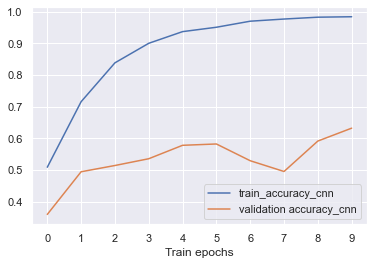

In [128]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [129]:
model6_rmsFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_rms.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [130]:
cnn_model_sgd = build_new_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
numEpochs = 20
startTime = time.time()
history_cnn = cnn_model_sgd.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model6_sgdTime = (endTime - startTime)

Epoch 1/20
188/188 [==============================] - 16s 72ms/step - loss: 1.3765 - accuracy: 0.2744 - val_loss: 1.3402 - val_accuracy: 0.5080
Epoch 2/20
188/188 [==============================] - 13s 72ms/step - loss: 1.3407 - accuracy: 0.3504 - val_loss: 1.2467 - val_accuracy: 0.6300
Epoch 3/20
188/188 [==============================] - 13s 71ms/step - loss: 1.2514 - accuracy: 0.4330 - val_loss: 1.0658 - val_accuracy: 0.6795
Epoch 4/20
188/188 [==============================] - 14s 73ms/step - loss: 1.1655 - accuracy: 0.4703 - val_loss: 0.9455 - val_accuracy: 0.6623
Epoch 5/20
188/188 [==============================] - 13s 72ms/step - loss: 1.1243 - accuracy: 0.4864 - val_loss: 0.9240 - val_accuracy: 0.6300
Epoch 6/20
188/188 [==============================] - 14s 72ms/step - loss: 1.0925 - accuracy: 0.5045 - val_loss: 0.8906 - val_accuracy: 0.6531
Epoch 7/20
188/188 [==============================] - 14s 72ms/step - loss: 1.0707 - accuracy: 0.5146 - val_loss: 0.9669 - val_accuracy:

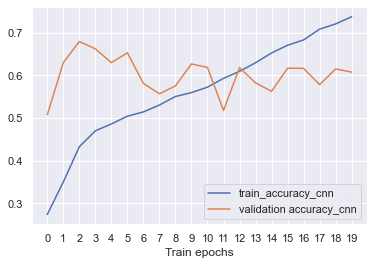

In [131]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [132]:
model6_sgdFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_sgd.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [133]:
cnn_model_adam = build_new_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model_adam.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model6_adamTime = (endTime - startTime)

Epoch 1/15
188/188 [==============================] - 17s 77ms/step - loss: 1.1033 - accuracy: 0.4887 - val_loss: 1.5752 - val_accuracy: 0.4912
Epoch 2/15
188/188 [==============================] - 14s 76ms/step - loss: 0.6261 - accuracy: 0.7383 - val_loss: 2.0088 - val_accuracy: 0.5122
Epoch 3/15
188/188 [==============================] - 14s 77ms/step - loss: 0.3275 - accuracy: 0.8720 - val_loss: 2.3660 - val_accuracy: 0.4467
Epoch 4/15
188/188 [==============================] - 14s 75ms/step - loss: 0.2044 - accuracy: 0.9239 - val_loss: 2.5373 - val_accuracy: 0.5260
Epoch 5/15
188/188 [==============================] - 14s 74ms/step - loss: 0.1294 - accuracy: 0.9543 - val_loss: 3.2110 - val_accuracy: 0.5029
Epoch 6/15
188/188 [==============================] - 14s 75ms/step - loss: 0.0889 - accuracy: 0.9673 - val_loss: 3.9326 - val_accuracy: 0.5340
Epoch 7/15
188/188 [==============================] - 14s 75ms/step - loss: 0.0774 - accuracy: 0.9730 - val_loss: 3.2114 - val_accuracy:

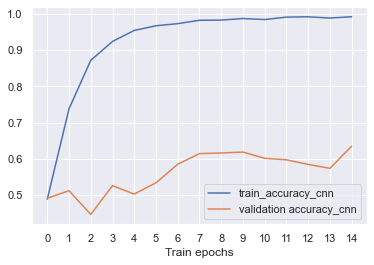

In [134]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [135]:
model6_adamFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_adam.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

The best optimizer was Adam
Training took 3.5700557827949524 minutes
75/75 [==============================] - 1s 11ms/step


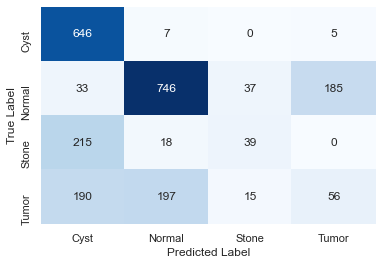

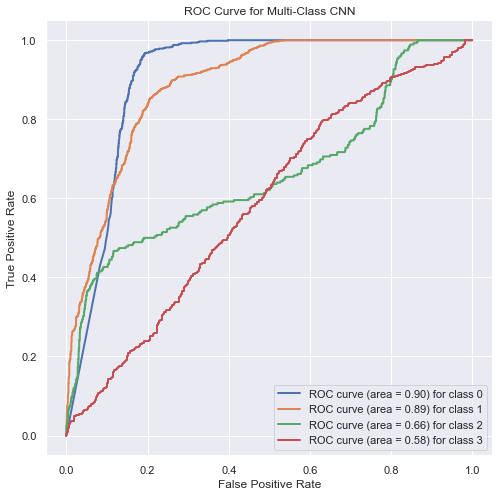

(0.6354123064043533,
 [0.6213364595545134,
  0.8233333333333334,
  0.4842105263157895,
  0.37153419593345655],
 [0.8054711246200608,
  0.7402597402597403,
  0.16911764705882354,
  0.4388646288209607])

In [136]:
if model6_sgdFinalValAcc >= model6_rmsFinalValAcc and model6_sgdFinalValAcc >= model6_adamFinalValAcc:
    print('The best optimizer was SGD')
    print('Training took ' + str(model5_sgdTime/60) + ' minutes')
    test_predictions = cnn_model_sgd.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model6accuracy, model6precisions, model6recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()


elif model6_rmsFinalValAcc >= model6_sgdFinalValAcc and model6_rmsFinalValAcc >= model6_adamFinalValAcc:
    print('The best optimizer was RMS')
    print('Training took ' + str(model6_rmsTime/60) + ' minutes')
    test_predictions = cnn_model_rms.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model6accuracy, model6precisions, model6recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
else:
    print('The best optimizer was Adam')
    print('Training took ' + str(model6_adamTime/60) + ' minutes')
    test_predictions = cnn_model_adam.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model6accuracy, model6precisions, model6recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()

model5accuracy, model5precisions, model5recalls

### Test CNN Model and Create ROC Curve
##### Now in above code block


In [ ]:
# predictions = cnn_model.predict(X_test_rgb)
# class_predictions = np.argmax(predictions, axis=-1)
# print(class_predictions)

In [ ]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize

# num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

## Ensemble Machine Learning Models

### Model 7 - Random Forest

In [142]:
if len(X_train.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_train.shape[0]
    X_train_flatish = X_train.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact


In [143]:
if len(X_test.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_test.shape[0]
    X_test_flatish = X_test.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact

In [145]:
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=42)

# Training the Random Forest classifier
startTime = time.time()
rf_classifier.fit(X_train_flatish, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

# Making predictions on the test set
predictions = rf_classifier.predict(X_test_flatish)

# Evaluating the model
accuracy = rf_classifier.score(X_test_flatish, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy}")

Training took 0.06865883270899455 minutes
Random Forest Classifier Accuracy: 0.5889493511929678


In [148]:
model7accuracy, model7precisions, model7recalls = allClassPrecisionsandRecalls(list(y_test), list(predictions))
model7accuracy, model7precisions, model7recalls

(0.5889493511929678,
 [0.5292479108635098,
  0.8102016607354685,
  0.21348314606741572,
  0.39862542955326463],
 [0.8662613981762918,
  0.6823176823176823,
  0.13970588235294118,
  0.25327510917030566])

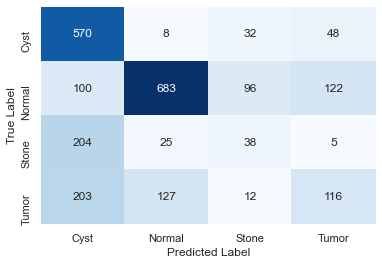

In [147]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 8 - XGBoost

In [149]:
model8 = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)
startTime = time.time()
model8.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 10.604246131579082 minutes


error: 0.42953020134228187
Val prediction accuracy: 0.570


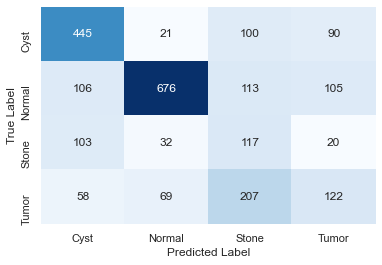

In [150]:
y_pred = model8.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

error: 0.45542067810799497
Test prediction accuracy: 0.545


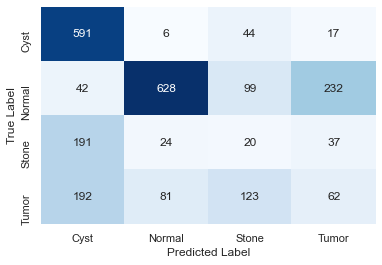

In [151]:
y_pred = model8.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [152]:
model8accuracy, model8precisions, model8recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
model8accuracy, model8precisions, model8recalls

(0.544579321892005,
 [0.5816929133858267,
  0.8497970230040596,
  0.06993006993006994,
  0.1781609195402299],
 [0.898176291793313,
  0.6273726273726273,
  0.07352941176470588,
  0.13537117903930132])

### Model 9 - Transfer Learning

In [ ]:
# Should have shape (12004, 256, 256, 1) at start of cell

print(X_train.shape, X_val.shape)
X_train_3_channel = X_train.repeat(3, axis=-1)
X_val_3_channel = X_val.repeat(3, axis = -1)

print(X_train_3_channel.shape, X_val_3_channel.shape)

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
               keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model9 = keras.Model(inputs, outputs)

model9.summary()

In [ ]:
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model9.fit(X_train_3_channel, 
                     y_train, 
                     epochs=10, 
                     batch_size=128, 
                     validation_data = (X_val_3_channel, y_val))
endTime = time.time()

print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = model9.predict(X_test_3_channel)
y_pred = np.argmax(test_predictions, axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

model9accuracy, model9precisions, model9recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Xception Transfer Learning')
plt.legend()
plt.show()

### Model 10 - ViT (Transfer Learning Vision Transformer)

In [ ]:
# Create base model
image_size = 256
basemodel10 = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False
    ,pretrained_top=False
#     ,classes=4
)

# Freeze base model
basemodel10.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = basemodel10(x, training = False)
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model10 = keras.Model(inputs, outputs)


model10.summary()

In [ ]:
model10.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model10.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, 
            validation_data = (X_val_3_channel, y_val), verbose = 1)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = model10.predict(X_test_3_channel)
y_pred = np.argmax(test_predictions, axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

model10accuracy, model10precisions, model10recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Xception Transfer Learning')
plt.legend()
plt.show()